In [1]:
import torch 
from sbi.analysis import pairplot

import matplotlib.pyplot as plt

from rbi.utils.datasets import get_datasets, get_reference_simulator
from rbi.utils.nets import MixtureDiagGaussianModel, MultivariateGaussianNet
from rbi.loss.loss_fn import NLLLoss

In [2]:
t_max = 10
time_points_observed = 8

train_loader, test_loader = get_datasets("lotka_volterra_forward", time_points_observed=time_points_observed, t_max=t_max, N_train=10000, N_test=5000, batch_size=256)
ref_simulator = get_reference_simulator("lotka_volterra")

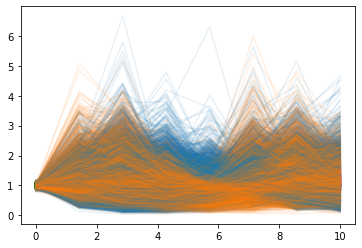

In [3]:
t = torch.linspace(0,t_max,time_points_observed)
for X, y in train_loader:
    plt.plot(t, y[:, :time_points_observed].T, color="C0", alpha=0.1)
    plt.plot(t, y[:, time_points_observed:].T, color="C1", alpha=0.1)

In [4]:
# net = MixtureDiagGaussianModel(4, 100, hidden_dims=[500, 500], num_components=10)
#net = AffineAutoregressiveModel(4, 100, hidden_dims=[100, 100], num_transforms=5, inverse_flow=True)
net = MultivariateGaussianNet(4, time_points_observed*2, hidden_dims=[400, 400])
loss_fn = NLLLoss(net)

In [5]:
optim = torch.optim.Adam(net.parameters(), lr=1e-3)

for i in range(50):
    for X,Y in train_loader:
        optim.zero_grad()
        loss = loss_fn(X,Y)
        loss.backward()
        torch.nn.utils.clip_grad_norm_(net.parameters(), 10.)
        optim.step()
    print(loss)

tensor(-3.8445, grad_fn=<AddBackward0>)
tensor(-8.4569, grad_fn=<AddBackward0>)
tensor(-12.6088, grad_fn=<AddBackward0>)
tensor(-13.2685, grad_fn=<AddBackward0>)
tensor(-12.5758, grad_fn=<AddBackward0>)
tensor(-15.8605, grad_fn=<AddBackward0>)
tensor(-15.1600, grad_fn=<AddBackward0>)
tensor(-17.2589, grad_fn=<AddBackward0>)
tensor(-22.0837, grad_fn=<AddBackward0>)
tensor(-19.1413, grad_fn=<AddBackward0>)
tensor(-18.5226, grad_fn=<AddBackward0>)
tensor(-14.2037, grad_fn=<AddBackward0>)
tensor(-18.2546, grad_fn=<AddBackward0>)
tensor(-22.1219, grad_fn=<AddBackward0>)
tensor(-24.4298, grad_fn=<AddBackward0>)
tensor(-23.2665, grad_fn=<AddBackward0>)
tensor(-20.9710, grad_fn=<AddBackward0>)
tensor(-24.8489, grad_fn=<AddBackward0>)
tensor(-20.5980, grad_fn=<AddBackward0>)
tensor(-27.2435, grad_fn=<AddBackward0>)
tensor(-22.2237, grad_fn=<AddBackward0>)
tensor(-26.0958, grad_fn=<AddBackward0>)
tensor(-22.2694, grad_fn=<AddBackward0>)
tensor(-21.7394, grad_fn=<AddBackward0>)
tensor(-22.0566, g

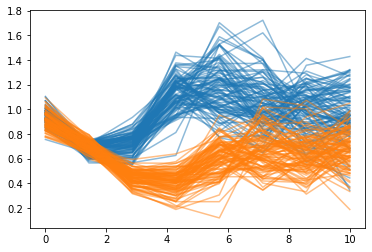

In [6]:
param = torch.randn(1,4).mul(0.3).exp().repeat(100,1)
sample = net(param).sample()
plt.plot(t,sample[:, :time_points_observed].T, color="C0", alpha=0.5)
_ = plt.plot(t,sample[:, time_points_observed:].T, color="C1", alpha=0.5)

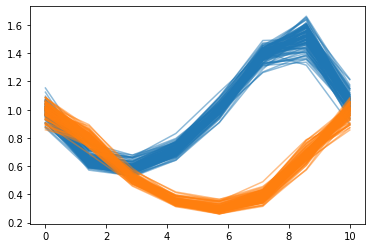

In [7]:
sol = ref_simulator(param, t_max, time_points_observed)
plt.plot(t,sol[:, :, 0], color="C0", alpha=0.5)
_ = plt.plot(t,sol[:, :, 1], color="C1", alpha=0.5)

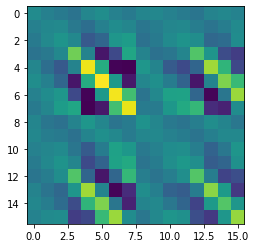

In [8]:
plt.imshow(net(param).covariance_matrix.clone().detach()[0])

In [9]:
from rbi.defenses.regularized_loss import GaussianNoiseJacobiRegularizer, WorstCaseJacobiRegularizer

In [79]:
net2 = MultivariateGaussianNet(4, time_points_observed*2, hidden_dims=[400, 400])
loss_fn = NLLLoss(net2)
defense = GaussianNoiseJacobiRegularizer(net2, loss_fn, 0.05)
defense.activate(algorithm="jvp_mc_approx", mc_samples=10)

In [80]:
optim = torch.optim.Adam(net2.parameters(), lr=1e-3)

for i in range(50):
    for X,Y in train_loader:
        optim.zero_grad()
        loss = loss_fn(X,Y)
        loss.backward()
        torch.nn.utils.clip_grad_norm_(net2.parameters(), 10.)
        optim.step()
    print(loss)

tensor(-4.0909, grad_fn=<AddBackward0>)
tensor(-11.2309, grad_fn=<AddBackward0>)
tensor(-12.5497, grad_fn=<AddBackward0>)
tensor(-7.8314, grad_fn=<AddBackward0>)
tensor(-12.0143, grad_fn=<AddBackward0>)
tensor(-14.6094, grad_fn=<AddBackward0>)
tensor(-9.1532, grad_fn=<AddBackward0>)
tensor(-16.2315, grad_fn=<AddBackward0>)
tensor(-16.6890, grad_fn=<AddBackward0>)
tensor(-14.1584, grad_fn=<AddBackward0>)
tensor(-16.8605, grad_fn=<AddBackward0>)
tensor(-16.9547, grad_fn=<AddBackward0>)
tensor(-15.0582, grad_fn=<AddBackward0>)
tensor(-17.3753, grad_fn=<AddBackward0>)
tensor(-18.8715, grad_fn=<AddBackward0>)
tensor(-19.4861, grad_fn=<AddBackward0>)
tensor(-18.1069, grad_fn=<AddBackward0>)
tensor(-18.2717, grad_fn=<AddBackward0>)
tensor(-15.7054, grad_fn=<AddBackward0>)
tensor(-9.8778, grad_fn=<AddBackward0>)
tensor(-18.9271, grad_fn=<AddBackward0>)
tensor(-17.0546, grad_fn=<AddBackward0>)
tensor(-23.1579, grad_fn=<AddBackward0>)
tensor(-12.4454, grad_fn=<AddBackward0>)
tensor(-18.8904, gra

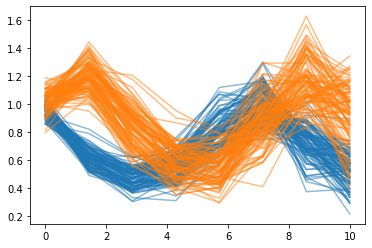

In [81]:
param = torch.randn(1,4).mul(0.3).exp().repeat(100,1)
sample = net2(param).sample()
plt.plot(t,sample[:, :time_points_observed].T, color="C0", alpha=0.5)
_ = plt.plot(t,sample[:, time_points_observed:].T, color="C1", alpha=0.5)

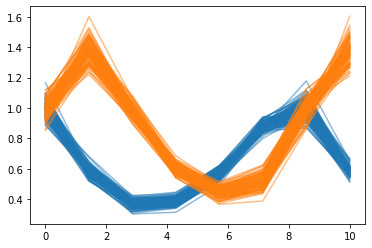

In [82]:
sol = ref_simulator(param, t_max, time_points_observed)
plt.plot(t,sol[:, :, 0], color="C0", alpha=0.5)
_ = plt.plot(t,sol[:, :, 1], color="C1", alpha=0.5)

In [83]:
from rbi.attacks.advertorch_attack import L2PGDAttack
from rbi.attacks.custom_attacks import WhiteNoiseAttack
from rbi.metrics.empirical_metrics import EmpiricalAdversarialTestLossMetric
from rbi.metrics.empirical_metrics import EmpiricalApproximationfKL
from rbi.loss.loss_fn import NegativeLogLikelihoodLoss, ForwardKLLoss

from rbi.visualization.robustness_eval_plots import plot_metric_for_pertubation_scales

In [84]:
adversarial_loss = ForwardKLLoss()
test_loss = NegativeLogLikelihoodLoss()

In [85]:
attack1 = L2PGDAttack(net, loss_fn=adversarial_loss, nb_iter=50, targeted=False)
attack2 = WhiteNoiseAttack()

In [86]:
m1 = EmpiricalAdversarialTestLossMetric(net, attack1, test_loss)
m2 = EmpiricalAdversarialTestLossMetric(net, attack2, test_loss)

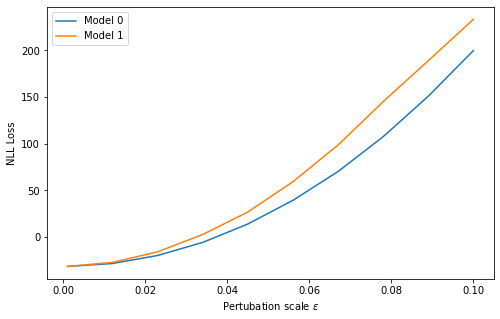

In [87]:
fig = plot_metric_for_pertubation_scales(torch.linspace(0.001, 0.1, 10), [m1, m2], test_loader)

In [88]:
adversarial_loss = ForwardKLLoss()
test_loss = NegativeLogLikelihoodLoss()

In [89]:
attack1 = L2PGDAttack(net2, loss_fn=adversarial_loss, nb_iter=50, targeted=False)
attack2 = WhiteNoiseAttack()

In [90]:
m1 = EmpiricalAdversarialTestLossMetric(net2, attack1, test_loss)
m2 = EmpiricalAdversarialTestLossMetric(net2, attack2, test_loss)

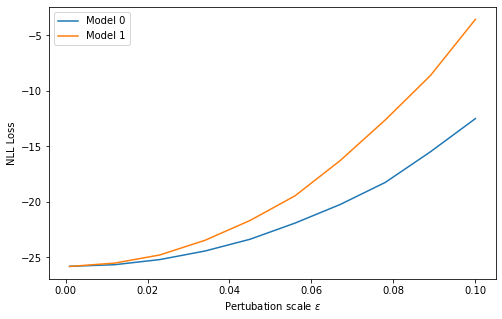

In [91]:
fig = plot_metric_for_pertubation_scales(torch.linspace(0.001, 0.1, 10), [m1, m2], test_loader)